In [41]:
import pyspark
from pyspark.sql import *
import pyspark.sql.functions as F
from pyspark.sql.types import *
import pandas as pd
import matplotlib as plt
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [5]:
spark = SparkSession.builder.getOrCreate()

In [34]:
# Read the parquet computed on the cluster and renamne columns
tones_df = spark.read.parquet("tone_mentions_europe.parquet")
tones = tones_df.toPandas()
tones.columns = ["DAY","MONTH","YEAR","tone_mean","STATE"]
tones.head()

,DAY,MONTH,YEAR,tone_mean,STATE
0,10,8,2017,-5.108700,VE
1,27,6,2016,-2.260378,VE
2,25,8,2017,-3.031185,PM
3,7,4,2015,-0.489160,KN
4,7,11,2017,-2.388809,KN


In [35]:
# Load the list of the countries in the world 
countries = pd.read_csv("countries_cleaned_europe.csv", delimiter=";")[["ISO", "Country", "Region"]]
countries.ISO = countries.ISO.str.upper()
countries.set_index("ISO", inplace=True)

regions = countries.Region.unique()[:-1]
print("Regions list:", regions)

fips_to_iso = pd.read_csv("fips-10-4-to-iso-country-codes.csv")
countries = countries.merge(fips_to_iso, how="left", left_index=True, right_on="ISO")
countries.drop(columns=["Name"], inplace=True)
countries.dropna()

countries.head()

Regions list: ['Africa' 'Americas' 'Asia' 'Europe' 'Oceania']


,Country,Region,FIPS,ISO
3,Algeria,Africa,AG,DZ
6,Angola,Africa,AO,AO
26,Benin,Africa,BN,BJ
31,Botswana,Africa,BC,BW
34,British Indian Ocean Territory,Africa,IO,IO


In [43]:
# Read the number of mentions computed by state and day on the cluster
counts_file = "mentions_counts_by_state_and_day.csv"
counts = pd.read_csv(counts_file)

From this point, we have loaded all the files needed to compute our visualization. Now we should clean them and join each of them.

In [44]:
# Join "table" with the list of countries
def join_country(table, states=None):
    table = table.merge(countries[["Country", "FIPS"]], how="inner", left_on="STATE", right_on="FIPS")
    table.dropna(inplace=True)
    table = table.assign(DATE=pd.to_datetime(table[["YEAR", "MONTH", "DAY"]]))
    #Filter by specific states
    if states is not None:
        table = table[table.STATE.isin(states)]
    #Drop not useful columns
    table.drop(columns=["FIPS", "YEAR", "MONTH", "DAY", "STATE"], inplace=True)
    return table

In [45]:
# We are interested only on European states
states = countries[countries.Region=="Europe"].FIPS.values

In [46]:
counts = join_country(counts,states)
counts.head()

,GLOBAL_COUNT,ENV_COUNT,Country,DATE
7020,568,48.0,Albania,2015-10-23
7021,246,60.0,Albania,2016-01-28
7022,337,136.0,Albania,2016-02-18
7023,52,2.0,Albania,2016-12-04
7025,1145,180.0,Albania,2016-05-30


In [47]:
tones = join_country(tones, states)
tones.head()

,tone_mean,Country,DATE
3305,-2.413834,Russia,2017-08-11
3306,-2.134429,Russia,2015-05-09
3307,-2.342646,Russia,2015-11-23
3308,-2.521173,Russia,2016-05-23
3309,-2.227376,Russia,2017-02-06


We have joined the count (count of mentions) and the tone tables with the table of countries (to get the real name of the country).

In [48]:
tones.describe()

,tone_mean
count,28977.000000
mean,-1.797039
std,1.598956
min,-26.488118
25%,-2.620469
50%,-2.007404
75%,-0.989501
max,11.564702


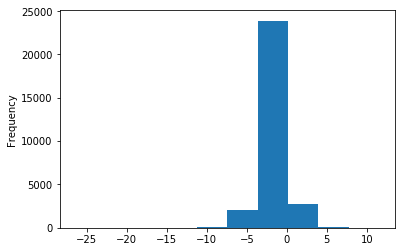

In [49]:
tones['tone_mean'].plot.hist()

In [19]:
q_plus = tones['tone_mean'].quantile(0.99)
q_minus = tones['tone_mean'].quantile(0.01)
print("99% quantile : {0:0.2f}" .format(q_plus))
print("1% quantile : {0:0.2f}" .format(q_minus))

99% quantile : 2.79
1% quantile : -5.79


In [20]:
tones = tones[(tones['tone_mean']>q_minus) & (tones['tone_mean']<q_plus)]

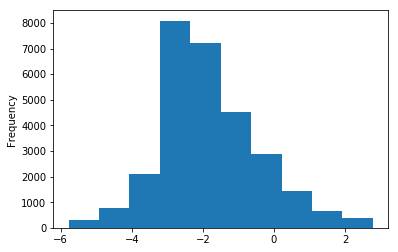

In [21]:
tones['tone_mean'].plot.hist()

As we are going to compute the mean tone over each country for each date, we need to clean out the tone table by removing outliers. To this purpose we remove, the 1% and the 99% quartiles

In [50]:
tones = tones.groupby([(pd.Grouper(key='DATE',freq='W')),"Country"]).mean()
tones = tones.reset_index()
tones.head()

,DATE,Country,tone_mean
0,2015-02-22,Albania,-2.328649
1,2015-02-22,Austria,-1.311470
2,2015-02-22,Belarus,-2.443157
3,2015-02-22,Belgium,-1.985543
4,2015-02-22,Bosnia and Herzegovina,-2.520943


In [51]:
counts = counts.groupby([(pd.Grouper(key='DATE',freq='W')),"Country"]).sum()
counts = counts.reset_index()
counts.head()

,DATE,Country,GLOBAL_COUNT,ENV_COUNT
0,2015-02-22,Albania,459,157.0
1,2015-02-22,Austria,4047,1061.0
2,2015-02-22,Belarus,6261,1318.0
3,2015-02-22,Belgium,7391,890.0
4,2015-02-22,Bosnia and Herzegovina,688,72.0


In [53]:
counts = counts.assign(Ratio=counts.ENV_COUNT/counts.GLOBAL_COUNT)
counts.drop(columns=['GLOBAL_COUNT','ENV_COUNT'],inplace=True)
counts.head()

,DATE,Country,Ratio
0,2015-02-22,Albania,0.342048
1,2015-02-22,Austria,0.262170
2,2015-02-22,Belarus,0.210510
3,2015-02-22,Belgium,0.120417
4,2015-02-22,Bosnia and Herzegovina,0.104651


We group by date and country computing the mean for the tone and the ratio of ecological mentions for the counts table.

In [54]:
count_tone = counts.merge(tones, on= ['DATE','Country'])
count_tone.head()

,DATE,Country,Ratio,tone_mean
0,2015-02-22,Albania,0.342048,-2.328649
1,2015-02-22,Austria,0.262170,-1.311470
2,2015-02-22,Belarus,0.210510,-2.443157
3,2015-02-22,Belgium,0.120417,-1.985543
4,2015-02-22,Bosnia and Herzegovina,0.104651,-2.520943


In [27]:
count_tone.describe()

,Ratio,tone_mean
count,5769.000000,5769.000000
mean,0.236984,-1.746940
std,0.127424,1.002820
min,0.009622,-5.780347
25%,0.151577,-2.411765
50%,0.209292,-1.860046
75%,0.293249,-1.204070
max,1.000000,2.743902


"count_tone" table is the final table that we are going to use for the visualization. We the average tone and the ratio of ecological mentions for each week for each european country.

In [55]:
# We seperate the table for each year
def sep_year(table):
    return table[table['DATE'] < '2016-01-01'],\
    table[(table['DATE'] < '2017-01-01') & (table['DATE'] >= '2016-01-01')],\
    table[(table['DATE'] < '2018-01-01') & (table['DATE'] >= '2017-01-01')]

In [56]:
counts_2015,counts_2016,counts_2017 = sep_year(count_tone)

In [57]:
# This function compute the visualization a circle scatter plot
def circle_scatter_plot(table,year):
    x_title = "Date in %d (weekly divided)" % (year)
    
    plot = alt.Chart(table).mark_circle(
        opacity=0.8,
        stroke='black',
        strokeWidth=1
    ).encode(
        alt.X('DATE:T', axis=alt.Axis(labelAngle=0, title=x_title)),
        alt.Y('Country:N'),
        alt.Size('Ratio:Q',
            legend=alt.Legend(title='Ratio of mentions')
        ),
        alt.Color('tone_mean:Q', scale=alt.Scale(range=['red','white','green']),legend=alt.Legend(title='Mean Tone'))
    ).properties(
        width=500,
        height=800
    ).properties(
    title='Time evolution of the ratio of ecological mentions and the average tone by European country')
    
    return plot


We represent the metric ratio by circles of different size and the metric tone by the color of the circles.
We plot a seperate visualization for each year as there will be too much information if we plot all the years on the same plot.

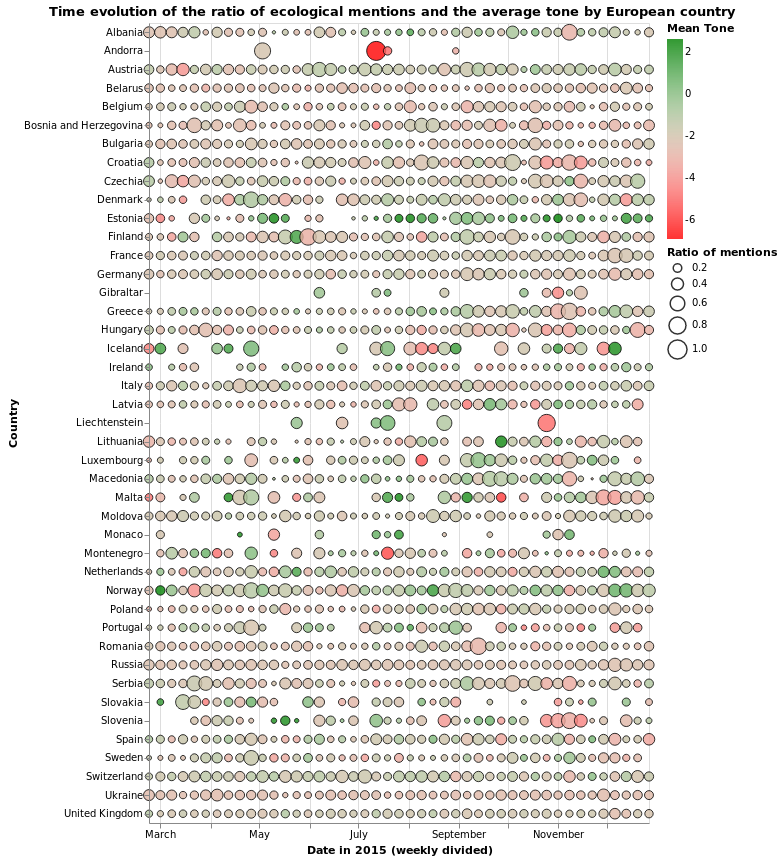

In [58]:
circle_scatter_plot(counts_2015,2015)

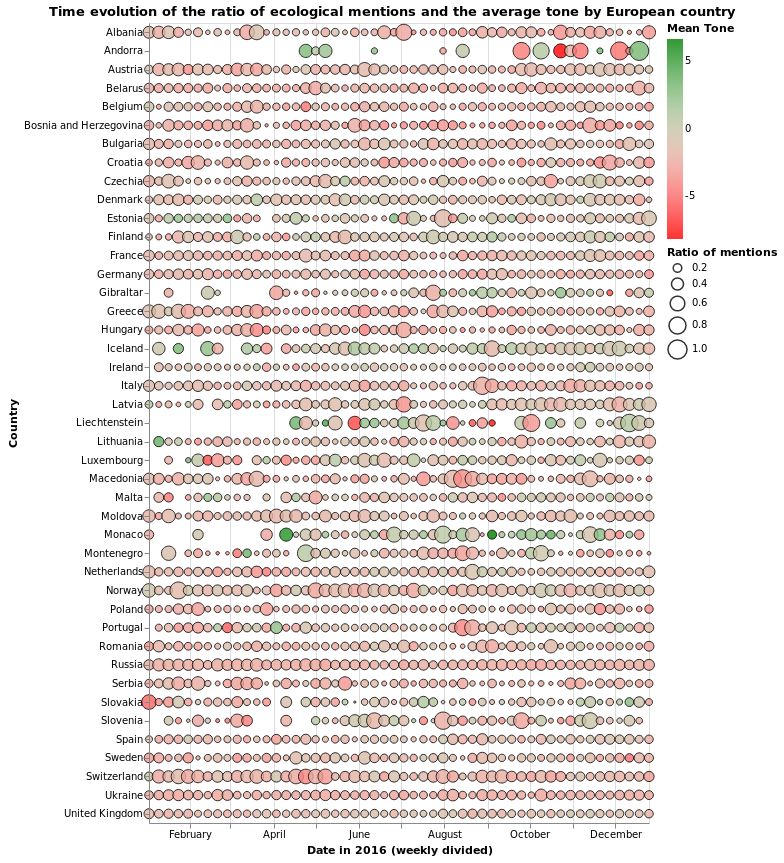

In [59]:
circle_scatter_plot(counts_2016,2016)

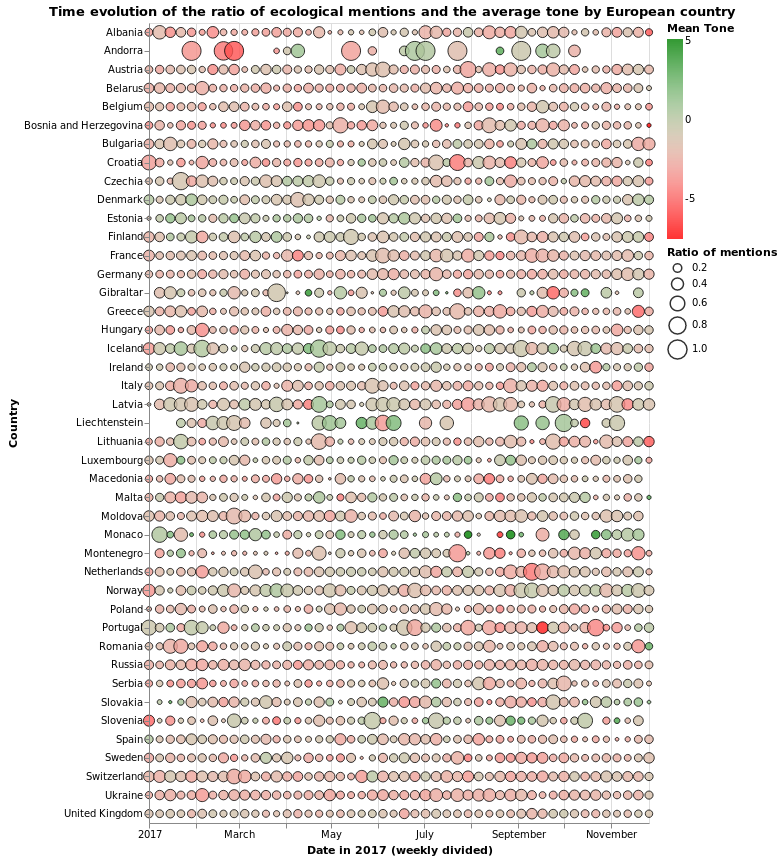

In [60]:
circle_scatter_plot(counts_2017,2017)